# Visualizations for Grevy's Zebra Behavioral Analysis
includes confidence intervals, p-values, and effect sizes


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality style
plt.style.use('default')  # Clean, publication-ready style
sns.set_palette("colorblind")  # Colorblind-friendly palette

# Custom color palette for consistency
# COLORS = {
#     'Walk': '#0173B2',      # Blue
#     'Head Up': '#DE8F05',   # Orange  
#     'Graze': '#029E73',     # Green
#     'Other': '#CC78BC'      # Purple
# }

ethogram = ['Out of Sight', 'Fight','Urinate','Mutual-Groom','Defecate','Auto-Groom','Browse','Trot/Run','Head Up','Walk','Graze', 'Other']
    
    # custom_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#d62728','#2ca02c','#8c564b','#e377c2','#7f7f7f','#17becf']
    # color_map = {behavior: custom_colors[i] for i, behavior in enumerate(ethogram)}
    
color = sns.color_palette("tab20", len(ethogram))
COLORS = {behavior: color[i] for i, behavior in enumerate(ethogram)}

In [4]:
# ============================================================================
# DATA PREPARATION 
# ============================================================================

# Load and prepare data
df = pd.read_csv('data/grevystimebudgetscleaned.csv')

# Encode categorical variables
le_habitat = LabelEncoder()
le_herd_size = LabelEncoder()
df['Habitat_encoded'] = le_habitat.fit_transform(df['Habitat'])
df['HerdSize_encoded'] = le_herd_size.fit_transform(df['Herd Size'])

behaviors = ['Walk', 'Head Up', 'Graze', 'Other']
X = df[['Habitat_encoded', 'HerdSize_encoded']]

# Calculate regression results with confidence intervals
def calculate_regression_stats(X, y):
    """Calculate regression statistics including confidence intervals"""
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    n = len(y)
    k = X.shape[1]
    
    # Residuals and MSE
    residuals = y - y_pred
    mse = np.sum(residuals**2) / (n - k - 1)
    
    # Design matrix with intercept
    X_with_intercept = np.column_stack([np.ones(n), X])
    
    try:
        # Covariance matrix
        cov_matrix = mse * np.linalg.inv(X_with_intercept.T @ X_with_intercept)
        se_coefs = np.sqrt(np.diag(cov_matrix))
        
        # t-statistics and p-values
        coefs_with_intercept = np.append(model.intercept_, model.coef_)
        t_stats = coefs_with_intercept / se_coefs
        p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), n - k - 1))
        
        # 95% Confidence intervals
        t_critical = stats.t.ppf(0.975, n - k - 1)
        ci_lower = coefs_with_intercept - t_critical * se_coefs
        ci_upper = coefs_with_intercept + t_critical * se_coefs
        
        return {
            'model': model,
            'r2': r2_score(y, y_pred),
            'coefficients': model.coef_,
            'intercept': model.intercept_,
            'se_coefs': se_coefs[1:],  # Exclude intercept
            'se_intercept': se_coefs[0],
            't_stats': t_stats[1:],    # Exclude intercept
            'p_values': p_values[1:],  # Exclude intercept
            'ci_lower': ci_lower[1:],  # Exclude intercept
            'ci_upper': ci_upper[1:],  # Exclude intercept
            'predictions': y_pred
        }
    except:
        return None

# Calculate stats for all behaviors
results = {}
for behavior in behaviors:
    results[behavior] = calculate_regression_stats(X, df[behavior])

In [69]:

# ============================================================================
# FIGURE 1: COEFFICIENT PLOT WITH CONFIDENCE INTERVALS
# ============================================================================

def create_coefficient_plot():
    """Create coefficient plot with confidence intervals"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    
    # Prepare data for plotting
    coef_data = []
    for behavior in behaviors:
        if results[behavior]:
            # Habitat coefficient
            coef_data.append({
                'Behavior': behavior,
                'Predictor': 'Habitat\n(Open vs Closed)',
                'Coefficient': results[behavior]['coefficients'][0],
                'CI_Lower': results[behavior]['ci_lower'][0],
                'CI_Upper': results[behavior]['ci_upper'][0],
                'P_Value': results[behavior]['p_values'][0],
                'SE': results[behavior]['se_coefs'][0]
            })
            
            # Herd Size coefficient  
            coef_data.append({
                'Behavior': behavior,
                'Predictor': 'Herd Size\n(Small vs Large)',
                'Coefficient': results[behavior]['coefficients'][1],
                'CI_Lower': results[behavior]['ci_lower'][1],
                'CI_Upper': results[behavior]['ci_upper'][1],
                'P_Value': results[behavior]['p_values'][1],
                'SE': results[behavior]['se_coefs'][1]
            })
    
    coef_df = pd.DataFrame(coef_data)
    
    # Plot 1: Habitat Effects
    habitat_data = coef_df[coef_df['Predictor'] == 'Habitat\n(Open vs Closed)']
    y_pos = np.arange(len(behaviors))
    
    colors_list = [COLORS[behavior] for behavior in behaviors]
    
    # Plot coefficients with error bars
    for i, (behavior, row) in enumerate(zip(behaviors, habitat_data.iterrows())):
        _, data = row
        
        # Plot coefficient (no alpha variation)
        ax1.barh(i, data['Coefficient'], color=colors_list[i], alpha=0.8, 
                height=0.6, edgecolor='black', linewidth=0.5)
        
        # Plot confidence interval
        ax1.errorbar(data['Coefficient'], i, 
                    xerr=[[data['Coefficient'] - data['CI_Lower']], 
                          [data['CI_Upper'] - data['Coefficient']]], 
                    fmt='none', color='black', capsize=4, capthick=1)
    
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(behaviors)
    ax1.set_xlabel('Coefficient (Open - Closed)', fontweight='bold')
    ax1.set_title('A) Habitat Effects', fontweight='bold', fontsize=14)
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax1.grid(axis='x', alpha=0.3)
    
    # print p-values in bottom left corner of each plot
    for i, (behavior, row) in enumerate(zip(behaviors, habitat_data.iterrows())):
        _, data = row
        p_val = data['P_Value']
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = 'ns'
    
    
    # Plot 2: Herd Size Effects
    herdsize_data = coef_df[coef_df['Predictor'] == 'Herd Size\n(Small vs Large)']
    
    for i, (behavior, row) in enumerate(zip(behaviors, herdsize_data.iterrows())):
        _, data = row
        
        # Plot coefficient (no alpha variation)
        ax2.barh(i, data['Coefficient'], color=colors_list[i], alpha=0.8,
                height=0.6, edgecolor='black', linewidth=0.5)
        
        # Plot confidence interval
        ax2.errorbar(data['Coefficient'], i,
                    xerr=[[data['Coefficient'] - data['CI_Lower']], 
                          [data['CI_Upper'] - data['Coefficient']]], 
                    fmt='none', color='black', capsize=4, capthick=1)
        
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(behaviors)
    ax2.set_xlabel('Coefficient (Small - Large)', fontweight='bold')
    ax2.set_title('B) Herd Size Effects', fontweight='bold', fontsize=14)
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax2.grid(axis='x', alpha=0.3)
    
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1, top=0.9)  # Add top padding for title
    return fig

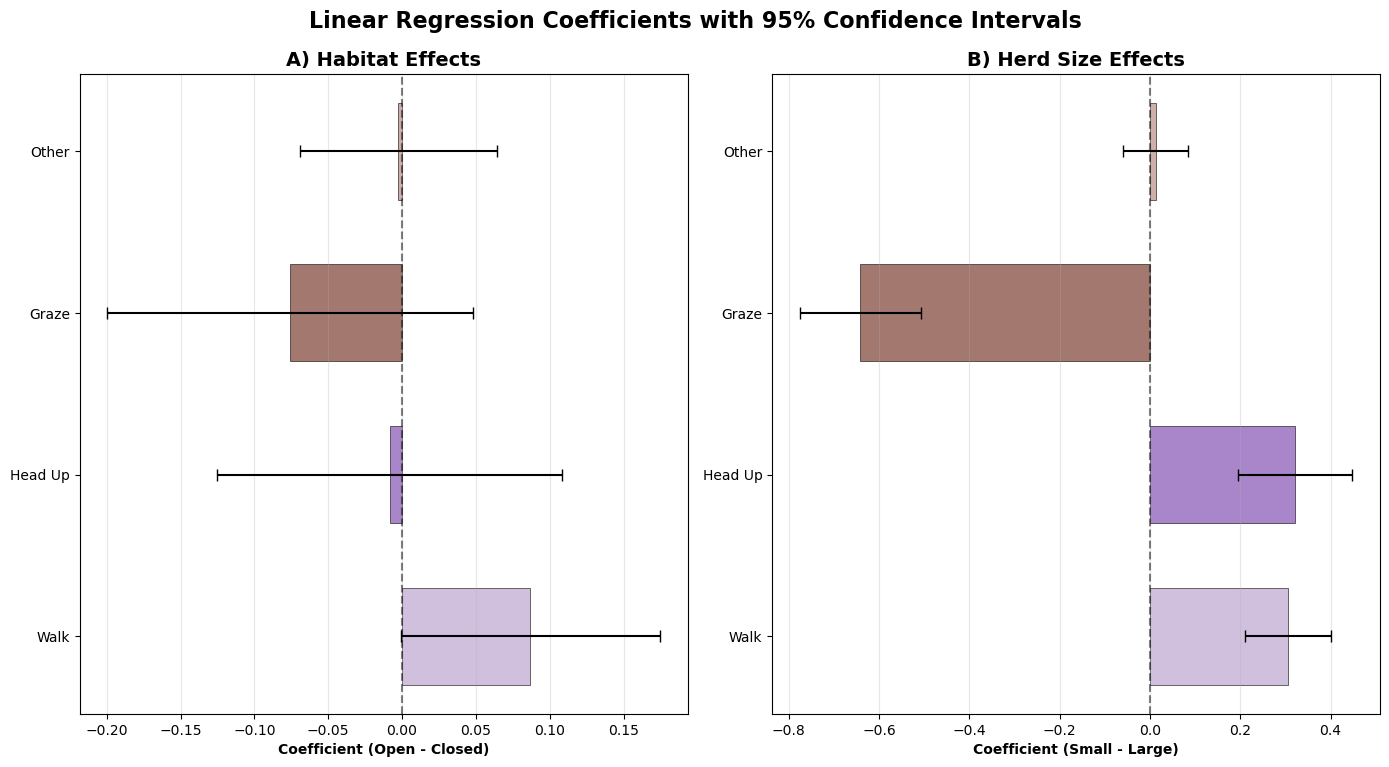

In [73]:
fig1 = create_coefficient_plot()
fig1.suptitle('Linear Regression Coefficients with 95% Confidence Intervals', 
              fontsize=16, fontweight='bold', y=0.98)
plt.show()

In [74]:
# ============================================================================
# FIGURE 2: MODEL PERFORMANCE AND EFFECT SIZES
# ============================================================================

def create_performance_plot():
    """Create model performance visualization with R² and effect sizes"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Prepare data
    r2_values = [results[behavior]['r2'] for behavior in behaviors]
    colors_list = [COLORS[behavior] for behavior in behaviors]
    
    # Plot 1: R² values with confidence intervals
    y_pos = np.arange(len(behaviors))
    bars = ax1.barh(y_pos, r2_values, color=colors_list, alpha=0.8,
                   height=0.6, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for i, (bar, r2_val) in enumerate(zip(bars, r2_values)):
        ax1.text(r2_val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{r2_val:.3f}', va='center', ha='left', fontweight='bold')
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(behaviors)
    ax1.set_xlabel('R² (Variance Explained)', fontweight='bold')
    ax1.set_title('A) Model Performance', fontweight='bold', fontsize=14)
    ax1.set_xlim(0, max(r2_values) * 1.2)
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: Effect Size Comparison (Cohen's f²)
    # Calculate Cohen's f² = R² / (1 - R²)
    cohens_f2 = [r2 / (1 - r2) if r2 < 1 else np.inf for r2 in r2_values]
    
    bars2 = ax2.barh(y_pos, cohens_f2, color=colors_list, alpha=0.8,
                    height=0.6, edgecolor='black', linewidth=0.5)
    
    # Add value labels and effect size interpretation
    for i, (bar, f2_val) in enumerate(zip(bars2, cohens_f2)):
        if f2_val < 0.02:
            effect_size = "trivial"
        elif f2_val < 0.15:
            effect_size = "small"
        elif f2_val < 0.35:
            effect_size = "medium"
        else:
            effect_size = "large"
        
        ax2.text(f2_val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{f2_val:.3f}\n({effect_size})', va='center', ha='left', fontsize=9)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(behaviors)
    ax2.set_xlabel('Cohen\'s f² (Effect Size)', fontweight='bold')
    ax2.set_title('B) Effect Size', fontweight='bold', fontsize=14)
    ax2.set_xlim(0, max(cohens_f2) * 1.3)
    ax2.grid(axis='x', alpha=0.3)
    
    # Add effect size reference lines
    ax2.axvline(x=0.02, color='gray', linestyle=':', alpha=0.7, label='Small (0.02)')
    ax2.axvline(x=0.15, color='gray', linestyle='--', alpha=0.7, label='Medium (0.15)')
    ax2.axvline(x=0.35, color='gray', linestyle='-', alpha=0.7, label='Large (0.35)')
    ax2.legend(loc='lower right', fontsize=8)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1, top=0.9)
    return fig



In [75]:
# ============================================================================
# FIGURE 3: PREDICTED MEANS WITH CONFIDENCE INTERVALS
# ============================================================================

def create_predicted_means_plot():
    """Create plot showing predicted means for each combination with CIs"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Calculate predicted means and confidence intervals
    combinations = [
        ('Closed', 'Large', 0, 0),   # Baseline
        ('Open', 'Large', 1, 0),     # Habitat effect only
        ('Closed', 'Small', 0, 1),   # Herd size effect only
        ('Open', 'Small', 1, 1)      # Both effects
    ]
    
    for i, behavior in enumerate(behaviors):
        ax = axes[i//2, i%2]
        
        if results[behavior] is None:
            continue
            
        model = results[behavior]['model']
        intercept = results[behavior]['intercept']
        habitat_coef = results[behavior]['coefficients'][0]
        herdsize_coef = results[behavior]['coefficients'][1]
        
        # Calculate predictions and standard errors
        x_positions = []
        predictions = []
        ci_lowers = []
        ci_uppers = []
        labels = []
        
        for j, (habitat, herd_size, h_code, hs_code) in enumerate(combinations):
            # Predicted value
            pred = intercept + habitat_coef * h_code + herdsize_coef * hs_code
            
            # For simplicity, use pooled SE (could be more sophisticated)
            # Standard error of prediction
            X_combo = np.array([[h_code, hs_code]])
            
            # Calculate actual observed values for this combination
            mask = (df['Habitat'] == habitat) & (df['Herd Size'] == herd_size)
            observed = df[mask][behavior]
            
            if len(observed) > 1:
                se_pred = stats.sem(observed)  # Standard error of the mean
                ci_lower = pred - 1.96 * se_pred
                ci_upper = pred + 1.96 * se_pred
            else:
                ci_lower = pred
                ci_upper = pred
            
            x_positions.append(j)
            predictions.append(pred)
            ci_lowers.append(ci_lower)
            ci_uppers.append(ci_upper)
            labels.append(f'{habitat}\n{herd_size}')
        
        # Plot predictions with confidence intervals
        ax.bar(x_positions, predictions, color=COLORS[behavior], alpha=0.7, 
               width=0.6, edgecolor='black', linewidth=0.5)
        
        # Add confidence intervals
        ax.errorbar(x_positions, predictions, 
                   yerr=[np.array(predictions) - np.array(ci_lowers),
                         np.array(ci_uppers) - np.array(predictions)],
                   fmt='none', color='black', capsize=5, capthick=1.5)
        
        # Add value labels
        for j, (x, pred) in enumerate(zip(x_positions, predictions)):
            ax.text(x, pred + (max(ci_uppers) - min(ci_lowers)) * 0.05, 
                   f'{pred:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        # Add observed data points as overlay
        for j, (habitat, herd_size, _, _) in enumerate(combinations):
            mask = (df['Habitat'] == habitat) & (df['Herd Size'] == herd_size)
            observed = df[mask][behavior]
            if len(observed) > 0:
                jittered_x = j + np.random.normal(0, 0.08, len(observed))
                ax.scatter(jittered_x, observed, color='red', alpha=0.6, s=20, 
                          edgecolor='darkred', linewidth=0.5, zorder=10)
        
        ax.set_xticks(x_positions)
        ax.set_xticklabels(labels, rotation=0)
        ax.set_ylabel('Proportion of Time', fontweight='bold')
        ax.set_title(f'{behavior}\n(R² = {results[behavior]["r2"]:.3f})', 
                    fontweight='bold', color=COLORS[behavior])
        ax.grid(axis='y', alpha=0.3)
        
        # Set y-axis to start from 0
        ax.set_ylim(0, max(ci_uppers) * 1.15)
    
    # Add overall legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='red', linestyle='', markersize=8, 
               alpha=0.6, label='Observed Data'),
        Line2D([0], [0], color='black', linestyle='-', label='95% Confidence Intervals')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=2)
    
    plt.suptitle('Predicted Behavior by Habitat and Herd Size Combinations', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1, top=0.92)
    return fig

Generating figures...


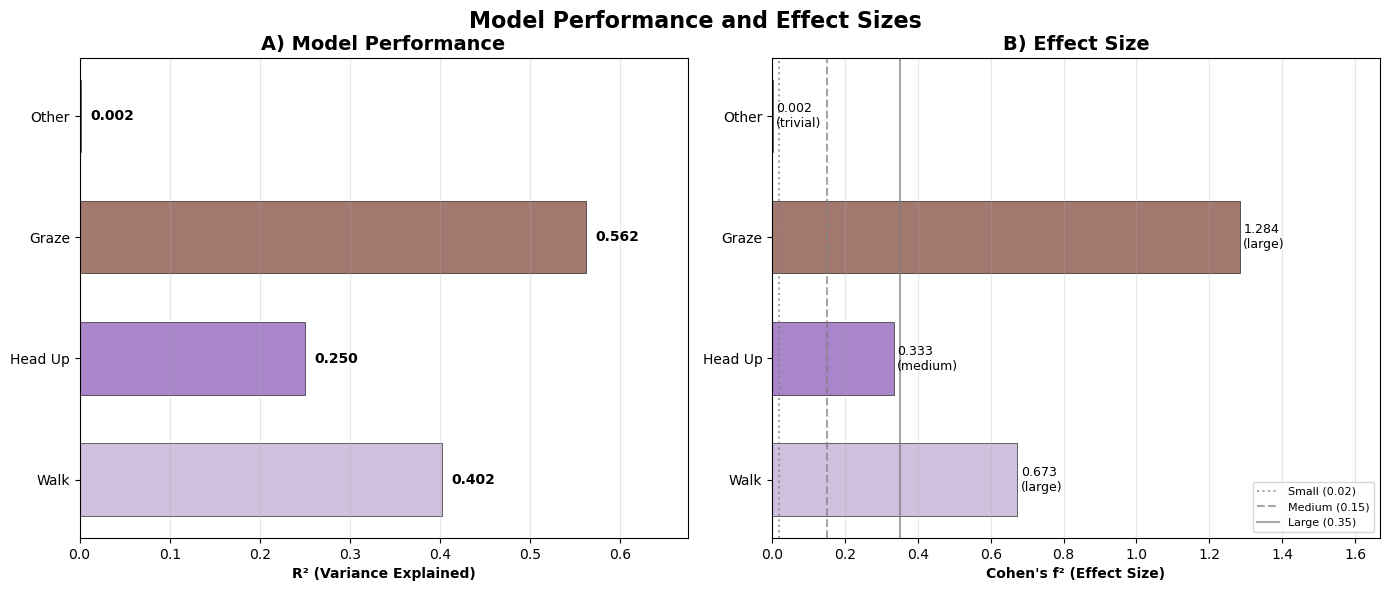

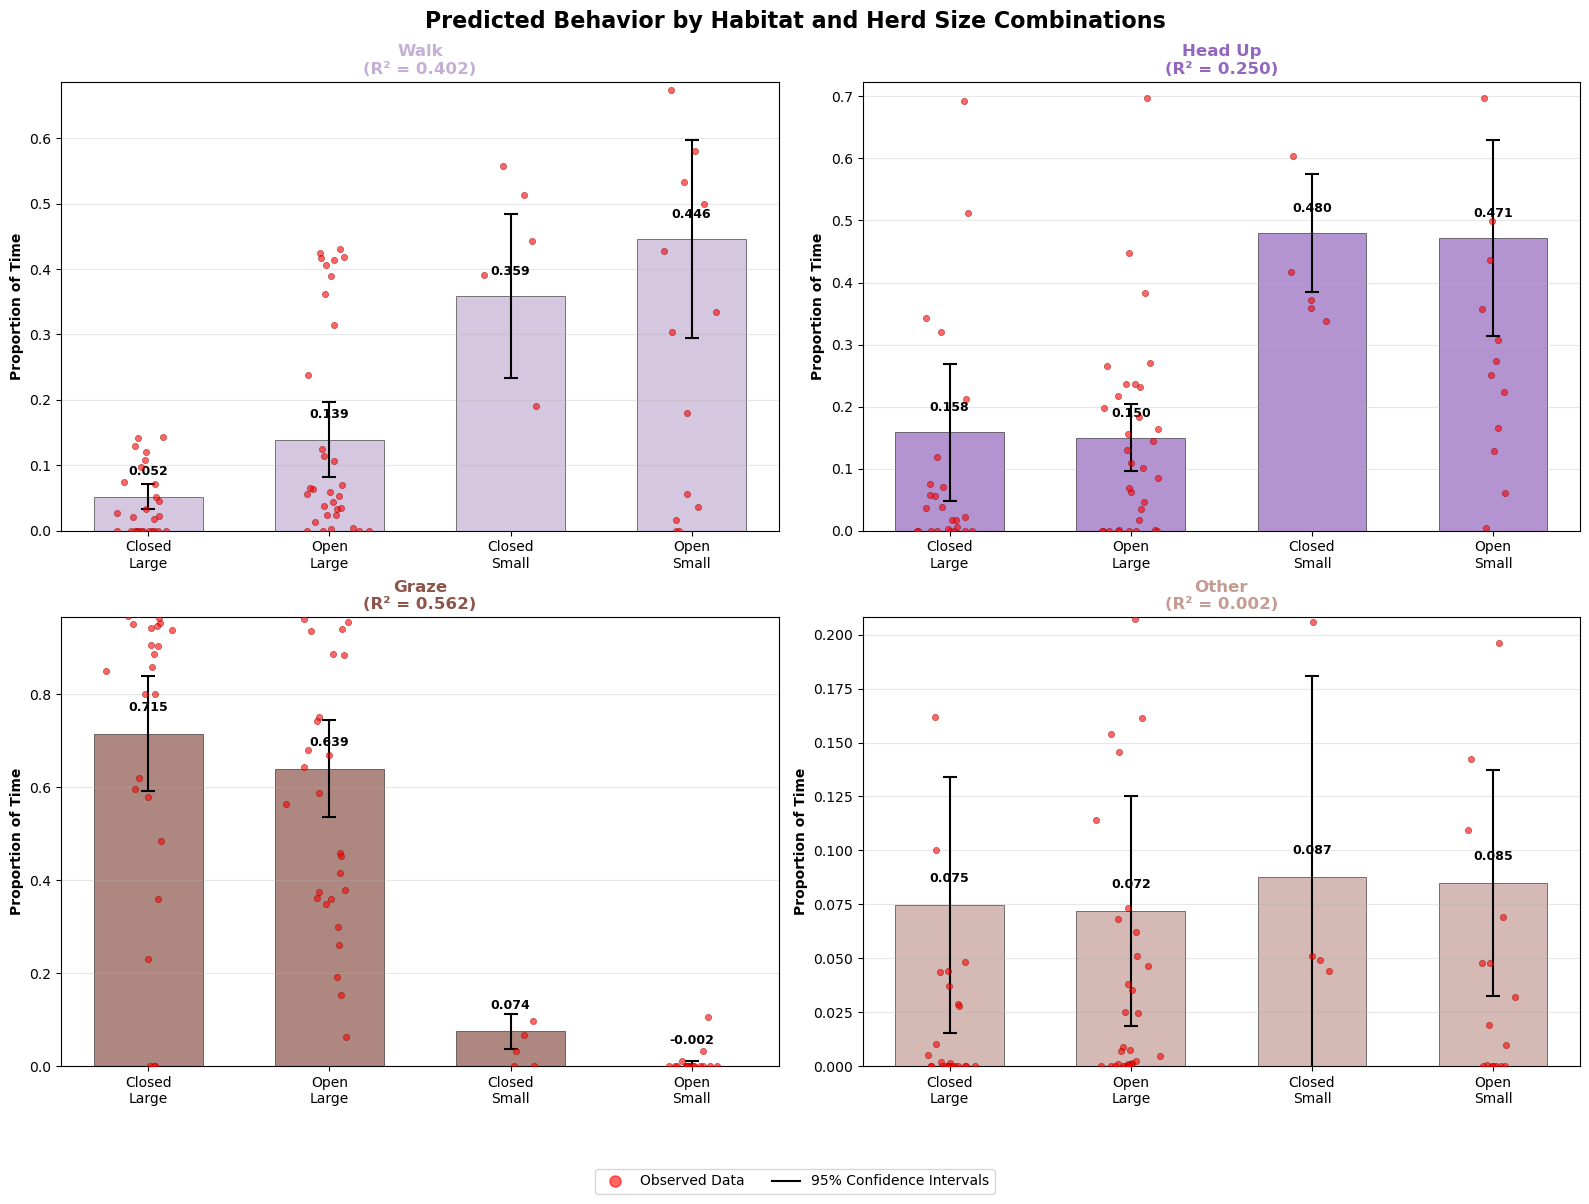

In [76]:
# ============================================================================
# GENERATE ALL FIGURES
# ============================================================================

# Create all figures
print("Generating figures...")


fig2 = create_performance_plot()
fig2.suptitle('Model Performance and Effect Sizes', 
              fontsize=16, fontweight='bold', y=0.98)
plt.show()

fig3 = create_predicted_means_plot()
plt.show()


In [77]:
print("\nSaving high-resolution figures for publication...")

# Save as both PNG (for presentations) and PDF (for publication)
fig1.savefig('figures/Figure1_Coefficients.png', dpi=300, bbox_inches='tight', facecolor='white')
fig1.savefig('figures/Figure1_Coefficients.pdf', dpi=300, bbox_inches='tight', facecolor='white')

fig2.savefig('figures/Figure2_Performance.png', dpi=300, bbox_inches='tight', facecolor='white')
fig2.savefig('figures/Figure2_Performance.pdf', dpi=300, bbox_inches='tight', facecolor='white')

fig3.savefig('figures/Figure3_PredictedMeans.png', dpi=300, bbox_inches='tight', facecolor='white')
fig3.savefig('figures/Figure3_PredictedMeans.pdf', dpi=300, bbox_inches='tight', facecolor='white')

print("figures/Figures saved successfully!")
print("\nFigure descriptions for manuscript:")
print("="*50)

print("""
Figure 1: Linear regression coefficients with 95% confidence intervals showing the effect of 
habitat (Open vs Closed) and herd size (Small vs Large) on four behaviors. Asterisks indicate 
statistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant. 
Solid bars indicate significant effects (p<0.05), transparent bars indicate non-significant effects.

Figure 2: Model performance metrics showing (A) proportion of variance explained (R²) and 
(B) effect sizes (Cohen's f²) for each behavioral model. Reference lines in panel B indicate 
conventional thresholds for small (0.02), medium (0.15), and large (0.35) effect sizes.

Figure 3: Predicted behavioral proportions for all habitat-herd size combinations with 95% 
confidence intervals. Red dots show observed individual data points with jittering to reduce 
overlap. Error bars represent confidence intervals around predicted means.
""")


Saving high-resolution figures for publication...
figures/Figures saved successfully!

Figure descriptions for manuscript:

Figure 1: Linear regression coefficients with 95% confidence intervals showing the effect of 
habitat (Open vs Closed) and herd size (Small vs Large) on four behaviors. Asterisks indicate 
statistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant. 
Solid bars indicate significant effects (p<0.05), transparent bars indicate non-significant effects.

Figure 2: Model performance metrics showing (A) proportion of variance explained (R²) and 
(B) effect sizes (Cohen's f²) for each behavioral model. Reference lines in panel B indicate 
conventional thresholds for small (0.02), medium (0.15), and large (0.35) effect sizes.

Figure 3: Predicted behavioral proportions for all habitat-herd size combinations with 95% 
confidence intervals. Red dots show observed individual data points with jittering to reduce 
overlap. Error bars represent confidence 